# Importing

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


# Creating Multi Criteria Decision Making class

In [2]:
class MCDM():
    def __init__(self):
        """The class provides two methods of Multi Criteria Decision Making - Analytics Hierarchy Process and 
        Technique for Order Preference by Similarity to Ideal Solution,
        and is currently limited by only 2-10 criteria. Out of range can cause errors"""
        
        # Experimental random index consistent with the number of criteria
        self.random_index_matrix = np.array([0, 0, 0.58, 0.9, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49])
    
    def normalization(self, data, benefits, technique):
        benefits = np.asarray(benefits).copy()
        benefits = benefits.astype(bool)

        data = data.copy()
        
        if technique == 'linear-max':
            data[:, benefits] = data[:, benefits] / data[:, benefits].max(axis = 0)
            data[:, ~benefits] = 1 - data[:, ~benefits] / data[:, ~benefits].max(axis = 0)
            
        elif technique == 'vector':        
            data[:, benefits] = data[:, benefits] / np.sqrt((data[:, benefits] ** 2).sum(axis = 0))
            data[:, ~benefits] = 1 - data[:, ~benefits] / np.sqrt((data[:, ~benefits] ** 2).sum(axis = 0))
            

        elif technique == 'linear-sum':
            data[:, benefits] = data[:, benefits] / data[:, benefits].sum(axis = 0)
            data[:, ~benefits] = 1 / data[:, ~benefits] / (1 / data[:, ~benefits]).sum(axis = 0)
        
        return data
        
    def consistency_evaluation(self, data, weights):
        weighted_matrix = data.dot(weights)
        weight_ratio = weighted_matrix / weights
        
        # Eigen value
        l_max = weight_ratio.mean()
        
        consistency_index = (l_max - self.n) / (self.n - 1)
        consistency_ratio = consistency_index / self.random_index
        
        return consistency_ratio
        
    def fit_AHP(self, criteria, technique = 'linear-sum'):
        criteria = np.asarray(criteria).copy()
        benefits = np.ones(criteria.shape[0]).astype(bool)
        
        self.n = criteria.shape[0]
        self.random_index = self.random_index_matrix[self.n - 1]
        
        normalized_criteria = self.normalization(criteria, benefits, technique = technique)
        
        ## make sure if it is correct
        weights = normalized_criteria.sum(axis = 1) / self.n
        weights = weights.reshape(-1, 1)
        
        self.consistency_ratio = self.consistency_evaluation(criteria, weights)
        
        if self.consistency_ratio >= 0.1:
            print('consistency ratio is {} - higher than 0.1'.format(self.consistency_ratio))

        elif self.consistency_ratio < 0:
            print('l_max is lower than {}'.format(self.n))
            
        self.weights = weights
        
    def fit_TOPSIS(self, data, benefits, technique = 'vector'):
        
        data = np.asarray(data).copy()
        benefits = np.asarray(benefits, dtype = bool).copy()

        try:
            self.weights
        except AttributeError:
            raise Exception('fit_AHP was not fit')
            
        normalized_data = self.normalization(data, benefits = benefits, technique = technique)
        weighted_data = normalized_data * self.weights.reshape(-1)

        V_plus = np.zeros(weighted_data.shape[1])
        V_minus = np.zeros(weighted_data.shape[1])
        
        V_plus[benefits] = weighted_data[:, benefits].max(axis = 0)
        V_plus[~benefits] = weighted_data[:, ~benefits].min(axis = 0)

        V_minus[benefits] = weighted_data[:, benefits].min(axis = 0)
        V_minus[~benefits] = weighted_data[:, ~benefits].max(axis = 0)

        S_plus = np.sqrt(((weighted_data - V_plus) ** 2).sum(axis = 1))
        S_minus = np.sqrt(((weighted_data - V_minus) ** 2).sum(axis = 1))
        
        self.performance_scores = S_minus / (S_plus + S_minus)

MCDM class contains four necessary functions, such as fit_AHP to establish weights for criteria, fit_TOPSIS to determine performance scores, consistency_evaluation to obtain consistency ratio, and normalization to normalize data. It is currently applicable in the range of 2-10 criteria.

In [3]:
# Normalization techniques
MCDM.normalization

<function __main__.MCDM.normalization(self, data, benefits, technique)>

In [4]:
# Determinign weights for each criteria
MCDM.fit_AHP

<function __main__.MCDM.fit_AHP(self, criteria, technique='linear-sum')>

In [5]:
# Finding consistency index for AHP
MCDM.consistency_evaluation

<function __main__.MCDM.consistency_evaluation(self, data, weights)>

In [6]:
# Calculating performance scores given weights
MCDM.fit_TOPSIS

<function __main__.MCDM.fit_TOPSIS(self, data, benefits, technique='vector')>

# Data Preparation

Importing data into notebooks

In [7]:
FILEPATH_TO_PWCM = '../data/data for location optimization/'
FILEPATH_TO_MONTH_DATA = '../data/monthly datasets for each location/'

FILENAME_1 = 'pwcm.xlsx'
FILENAME_2 = 'September.csv'
FILENAME_3 = 'October.csv'
FILENAME_4 = 'November.csv'

# PairWise Comparison Matrix
pwcm = pd.read_excel(FILEPATH_TO_PWCM + FILENAME_1)

# Location data for September month
september_data = pd.read_csv(FILEPATH_TO_MONTH_DATA + FILENAME_2)
october_data = pd.read_csv(FILEPATH_TO_MONTH_DATA + FILENAME_3)
november_data = pd.read_csv(FILEPATH_TO_MONTH_DATA + FILENAME_4)

In [8]:
september_data.shape

(985, 36)

In [9]:
september_data.head()

,Latitude,Longitude,Elevation,Distance from Armenia,Slope,landcover_10,landcover_20,landcover_30,landcover_40,landcover_50,...,Soil Moisture,Soil Temperature,b0_0,b0_1,b0_4,b0_5,b0_6,b0_7,b0_9,Aspect
0,38.93,46.58,2944,4.592230,31.519659,5030.627445,18336.25269,0.0,6683.010795,86891.09746,...,0.213664,292.579437,87088.19760,98844.27183,942.041732,85077.81331,128884.2711,0.000000,11853.450220,28.801444
1,38.97,46.58,2756,4.461349,22.879574,2333.382047,15324.64939,0.0,4978.872489,83997.13059,...,0.234046,291.694611,84296.84740,95038.49995,505.381565,81330.52993,124498.5771,0.000000,7449.897142,118.691951
2,38.97,46.50,2872,1.512298,29.273340,2754.700458,21270.57019,0.0,11894.978200,89443.91999,...,0.213664,292.579437,89866.55624,98860.83868,6410.808309,85333.65598,125852.1635,0.000000,11025.815270,37.270103
3,38.97,46.62,2783,7.368732,4.760822,3972.602137,12723.26262,0.0,1520.833922,81356.00783,...,0.210990,295.879028,81587.85193,93259.03083,0.000000,79477.23039,123958.7479,1847.886281,7635.981889,92.626847
4,38.97,46.66,2959,10.611305,17.690387,4149.814222,10621.03629,0.0,1937.265029,78777.12774,...,0.210990,295.879028,78936.40489,91574.27133,1937.265029,77732.32639,123511.8919,0.000000,9220.060659,80.913842


In [10]:
pwcm.set_index('index', inplace = True)
pwcm

,Solar Potential,Landcover,Soil Moisture,Soil Texture,Slope,Aspect
index,,,,,,
Solar Potential,1.000000,3.000000,4.0,6,8,8
Landcover,0.333333,1.000000,1.0,2,3,3
Soil Moisture,0.250000,1.000000,1.0,2,2,2
Soil Texture,0.166667,0.500000,0.5,1,1,1
Slope,0.125000,0.333333,0.5,1,1,1
Aspect,0.125000,0.333333,0.5,1,1,1


In [11]:
pwcm.shape

(6, 6)

Choosing necessary columns and manipulating data to fit to the ideal format for input

In [12]:
landcover_columns = ['landcover_10', 'landcover_20', 'landcover_50', 'landcover_80', 'landcover_90', 'landcover_100']
soiltexture_columns = ['b0_0', 'b0_1', 'b0_5', 'b0_6', 'b0_9']

september_data['Landcover'] = september_data[landcover_columns].min(axis = 1)
september_data['Soil Texture'] = september_data[soiltexture_columns].min(axis = 1)

october_data['Landcover'] = october_data[landcover_columns].min(axis = 1)
october_data['Soil Texture'] = october_data[soiltexture_columns].min(axis = 1)

november_data['Landcover'] = november_data[landcover_columns].min(axis = 1)
november_data['Soil Texture'] = november_data[soiltexture_columns].min(axis = 1)

In [13]:
prepared_september_data = september_data[pwcm.columns].copy()
prepared_october_data = october_data[pwcm.columns].copy()
prepared_november_data = november_data[pwcm.columns].copy()

In [14]:
prepared_september_data.head(10)

,Solar Potential,Landcover,Soil Moisture,Soil Texture,Slope,Aspect
0,154.815897,5030.627445,0.213664,11853.450220,31.519659,28.801444
1,152.629103,2333.382047,0.234046,7449.897142,22.879574,118.691951
2,150.486632,2754.700458,0.213664,11025.815270,29.273340,37.270103
3,153.690789,3972.602137,0.210990,7635.981889,4.760822,92.626847
4,154.210562,4149.814222,0.210990,9220.060659,17.690387,80.913842
5,148.334960,0.000000,0.224990,3172.311284,29.420431,148.976753
6,151.803469,0.000000,0.212777,3587.370113,35.268259,172.446560
7,153.574444,2086.587694,0.212777,6031.618971,16.634002,80.109610
8,154.109736,5088.779720,0.215566,8620.567681,2.204745,149.866752
9,148.454748,0.000000,0.228703,2047.451234,15.744254,78.910653


In [15]:
# Locations will be used later for visualization
locs = september_data[['Latitude', 'Longitude']].copy()

# MCDM Modeling

## AHP

In [16]:
model = MCDM()
model.fit_AHP(pwcm, technique = 'linear-sum')

In [17]:
model.consistency_ratio < .1

True

In [18]:
model.weights

array([[0.49689305],
       [0.16516805],
       [0.13739027],
       [0.07216736],
       [0.06419063],
       [0.06419063]])

We can clearly see weights of each criteria

In [19]:
pd.DataFrame({'criteria': pwcm.columns, 'weights': model.weights.reshape(-1)})

,criteria,weights
0,Solar Potential,0.496893
1,Landcover,0.165168
2,Soil Moisture,0.137390
3,Soil Texture,0.072167
4,Slope,0.064191
5,Aspect,0.064191


## TOPSIS

Before fitting TOPSIS, first we define benefits list. 0 indicates that the less the value in the corresponding criteria the better while 1 refers to reverse case. In short, they are called cost and benefit, respectively.

In [20]:
benefits = [1, 1, 0, 1, 0, 0]

For example, higher values of power is **beneficial** for us indicated by 1, whereas we don't want to construct panels in mountains, therefore, slope must be as lower as possible indicated by 0 - **cost**. 

In [21]:
pd.DataFrame({'criteria': pwcm.columns, 'benefits': benefits})

,criteria,benefits
0,Solar Potential,1
1,Landcover,1
2,Soil Moisture,0
3,Soil Texture,1
4,Slope,0
5,Aspect,0


Fitting TOPSIS.

In [22]:
model.fit_TOPSIS(prepared_september_data, benefits, technique = 'vector')
ps_september = model.performance_scores

model.fit_TOPSIS(prepared_october_data, benefits, technique = 'vector')
ps_october = model.performance_scores

model.fit_TOPSIS(prepared_november_data, benefits, technique = 'vector')
ps_november = model.performance_scores

In [23]:
# lower and upper boundaries
lower_b, upper_b = 1, 3

ps_september = (ps_september - ps_september.min()) / (ps_september.max() - ps_september.min()) * (upper_b - lower_b) + lower_b
ps_october = (ps_october - ps_october.min()) / (ps_october.max() - ps_october.min()) * (upper_b - lower_b) + lower_b
ps_november = (ps_november - ps_november.min()) / (ps_november.max() - ps_november.min()) * (upper_b - lower_b) + lower_b

In [24]:
prepared_september_data['Performance Score'] = ps_september
prepared_october_data['Performance Score'] = ps_october
prepared_november_data['Performance Score'] = ps_november

Scores were successfully produced! 

In [25]:
prepared_september_data.head(10)

,Solar Potential,Landcover,Soil Moisture,Soil Texture,Slope,Aspect,Performance Score
0,154.815897,5030.627445,0.213664,11853.450220,31.519659,28.801444,1.785963
1,152.629103,2333.382047,0.234046,7449.897142,22.879574,118.691951,1.490940
2,150.486632,2754.700458,0.213664,11025.815270,29.273340,37.270103,1.520131
3,153.690789,3972.602137,0.210990,7635.981889,4.760822,92.626847,1.566733
4,154.210562,4149.814222,0.210990,9220.060659,17.690387,80.913842,1.630462
5,148.334960,0.000000,0.224990,3172.311284,29.420431,148.976753,1.371232
6,151.803469,0.000000,0.212777,3587.370113,35.268259,172.446560,1.437097
7,153.574444,2086.587694,0.212777,6031.618971,16.634002,80.109610,1.426315
8,154.109736,5088.779720,0.215566,8620.567681,2.204745,149.866752,1.710446
9,148.454748,0.000000,0.228703,2047.451234,15.744254,78.910653,1.269238


# Analysis and Data Manipulation

The following subplots demonstrate that results of each month - September, October and November - are pretty similar.

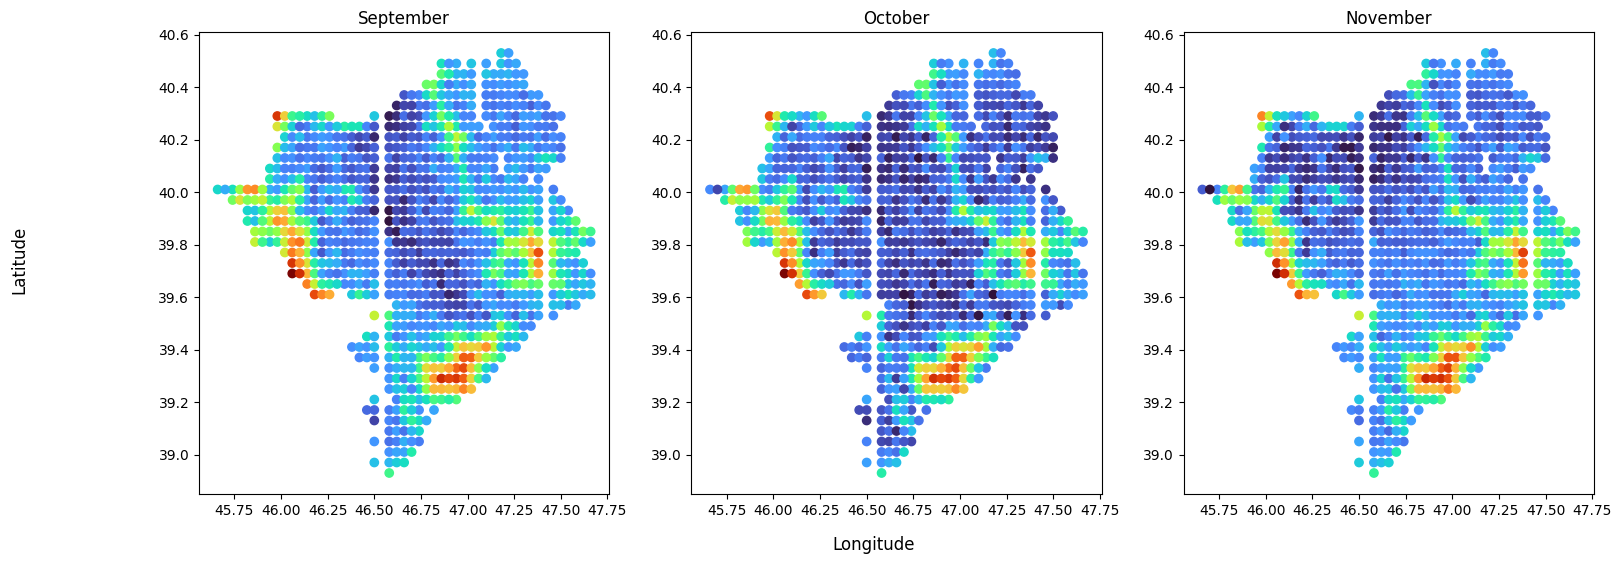

In [26]:
data = [prepared_september_data, prepared_october_data, prepared_november_data]
months = ['September', 'October', 'November']
fig = plt.figure(figsize = (18, 6))
fig.supxlabel('Longitude')
fig.supylabel('Latitude')

for i in range(1, 4):
    ax = plt.subplot(1, 3, i)
    ax.scatter(locs['Longitude'], locs['Latitude'], c = data[i - 1]['Performance Score'], cmap = 'turbo')
    ax.set_title(months[i - 1])    

There are some locations that are not suitable for construction of solar panels, such as tree cover, water resources, etc.
In the rest of code, we conduct data manipulation to manually set performance scores of inappropriate locations as 1.

In [27]:
landcover_types = np.array([10, 20, 30, 40, 50, 60, 80, 90, 100])

indexes = september_data.loc[:, 'landcover_10':'landcover_100'].values.argmin(1)
landcover_types = landcover_types[indexes]

In [28]:
conditions = (landcover_types != 30) & (landcover_types != 40) & (landcover_types != 60)

In [29]:
prepared_september_data.loc[conditions, 'Performance Score'] = 1
prepared_october_data.loc[conditions, 'Performance Score'] = 1
prepared_november_data.loc[conditions, 'Performance Score'] = 1

Final plots

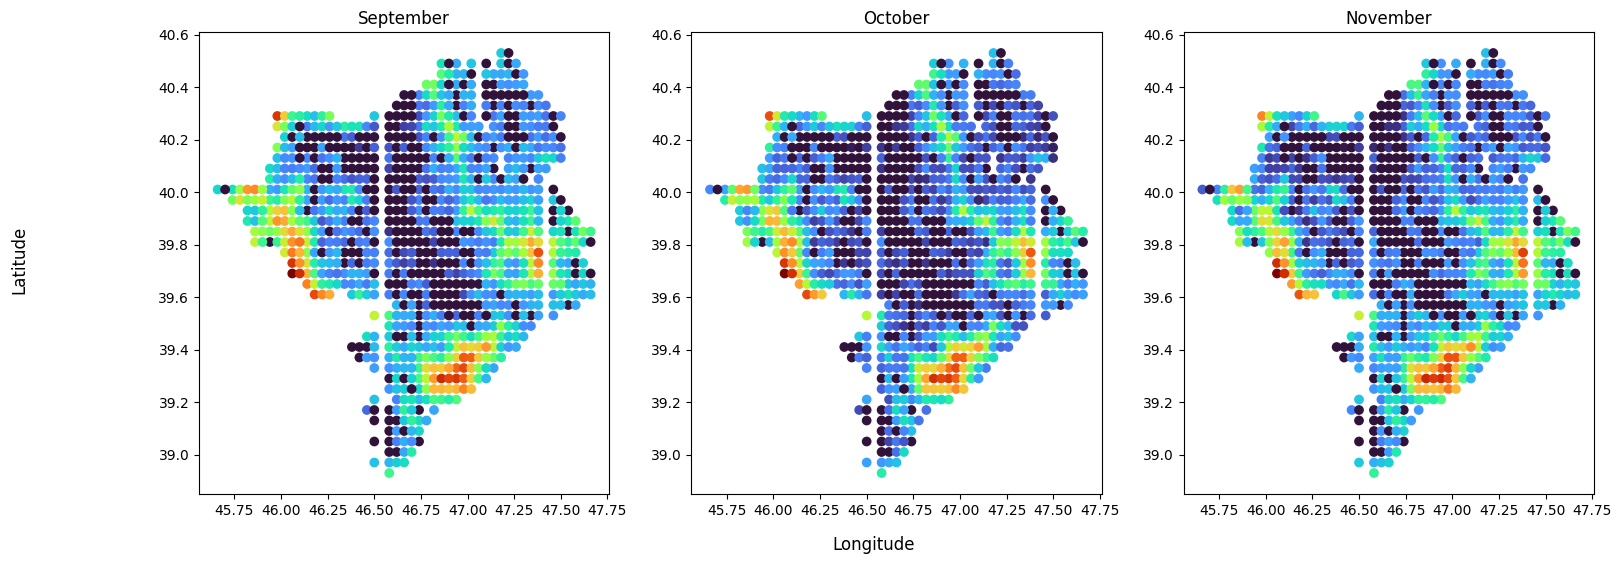

In [30]:
data = [prepared_september_data, prepared_october_data, prepared_november_data]
months = ['September', 'October', 'November']
fig = plt.figure(figsize = (18, 6))
fig.supxlabel('Longitude')
fig.supylabel('Latitude')

for i in range(1, 4):
    ax = plt.subplot(1, 3, i)
    ax.scatter(locs['Longitude'], locs['Latitude'], c = data[i - 1]['Performance Score'], cmap = 'turbo')
    ax.set_title(months[i - 1])    

In [31]:
average_scores = (prepared_september_data['Performance Score'] + 
 prepared_october_data['Performance Score'] + 
 prepared_november_data['Performance Score']) / 3

In [32]:
locs['Performance Score'] = average_scores

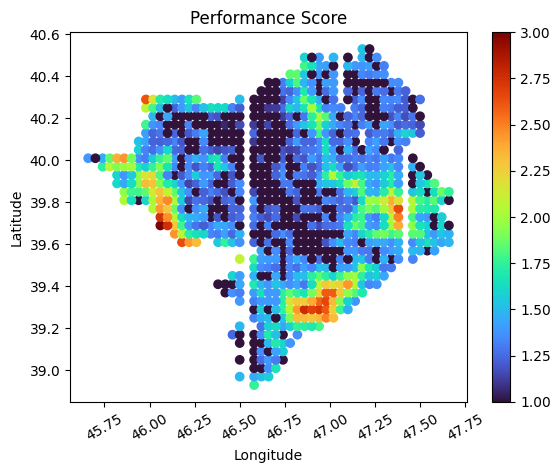

In [33]:
plt.scatter(locs['Longitude'], locs['Latitude'], c = locs['Performance Score'], cmap = 'turbo')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Performance Score')
plt.xticks(rotation = 30)
plt.colorbar()
plt.savefig('images/Performance Scores.png')
plt.show()

Saving scores

In [34]:
locs.to_csv('../data/produced scores/final_scores.csv', index = False)